In [4]:
!pip install tqdm
!pip install keras
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')



In [0]:
ndim = 100

(X_train, y_train), (X_test, y_test) =mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784) #reshaping 28*28 to 784

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=ndim)) #give output dimension of size 256 and takes input of 100
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh')) #784 because dimension of input is 784=28*28
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)



In [0]:
# Combined network
discriminator.trainable = False #we make this false becase we dont want discrimainator to learn from generated images when it passes through it
ganInput = Input(shape=(ndim,))
x = generator(ganInput)
ganOutput = discriminator(x)

#print ganOutput
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []



In [0]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, ndim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)



In [0]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize #total no. of batches
    print 'epochs:', epochs
    print 'batch size:', batchSize
    print 'batches per epoch:', batchCount
    print generator.summary()
    print discriminator.summary()

    for e in xrange(1, epochs+1):
        print'Epoch %d' % e
        for tj in tqdm(xrange(batchCount)):
            
            noise = np.random.normal(0, 1, size=[batchSize, ndim])  # random set of input noise and images
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            
            generatedImages = generator.predict(noise)  # generate images
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            
            yDis = np.zeros(2*batchSize)  # Labels for generated and real data
            
            yDis[:batchSize] = 0.9 #create an array of equal no. of 0.9,0 [0.9,0.9...... 0,0,0]
            

            
            discriminator.trainable = True # train discriminator
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, ndim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        
        dLosses.append(dloss)
        gLosses.append(gloss)
        plotGeneratedImages(e)
        
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % e)



  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 8
Batch size: 128
Batches per epoch: 468
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)           


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


 36%|███▌      | 169/468 [00:29<00:51,  5.78it/s]


 74%|███████▎  | 344/468 [00:57<00:20,  6.00it/s]


  0%|          | 1/468 [00:00<01:09,  6.68it/s]

Epoch 2


  0%|          | 1/468 [00:00<01:10,  6.66it/s]

Epoch 3


  0%|          | 1/468 [00:00<01:12,  6.43it/s]

Epoch 4


  0%|          | 1/468 [00:00<01:19,  5.87it/s]

Epoch 5


  0%|          | 1/468 [00:00<01:17,  6.04it/s]

Epoch 6


  0%|          | 1/468 [00:00<01:26,  5.39it/s]

Epoch 7


  0%|          | 1/468 [00:00<01:24,  5.54it/s]

Epoch 8


100%|██████████| 468/468 [01:12<00:00,  6.49it/s]


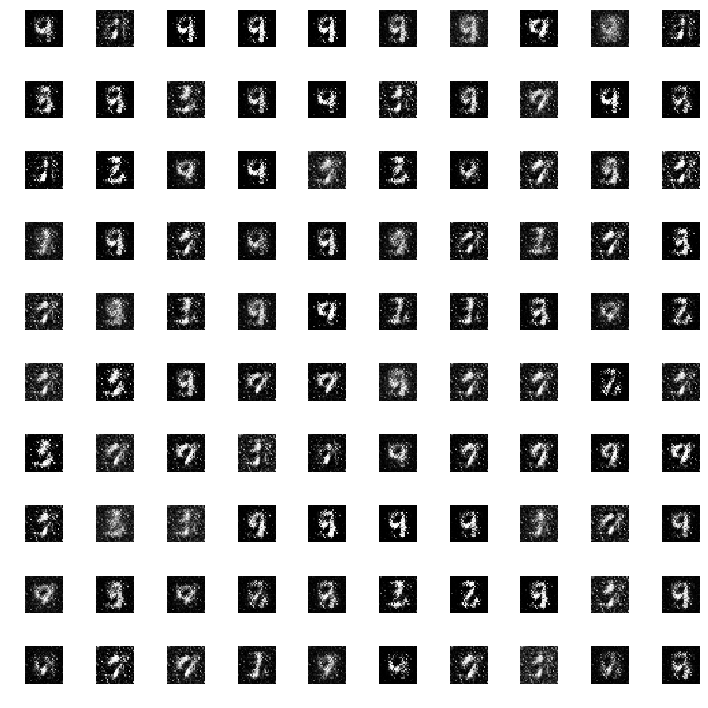

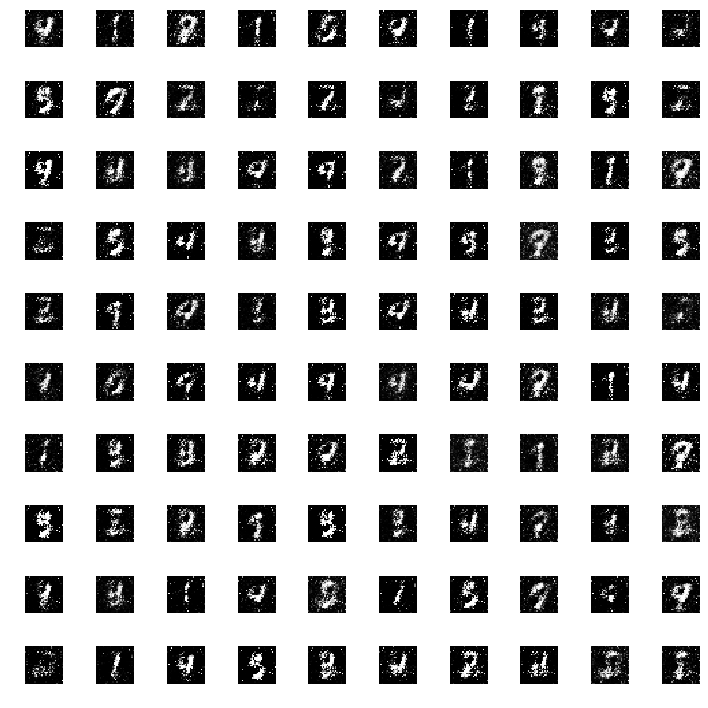

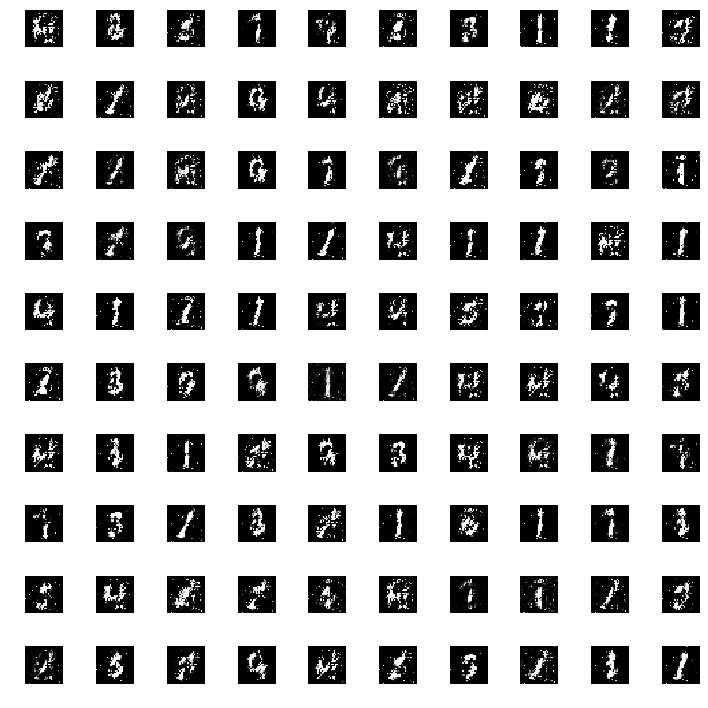

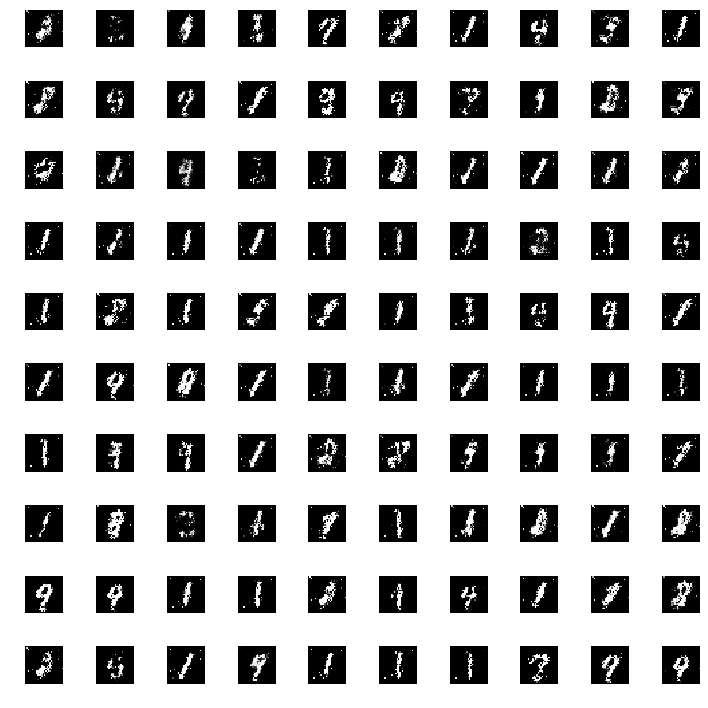

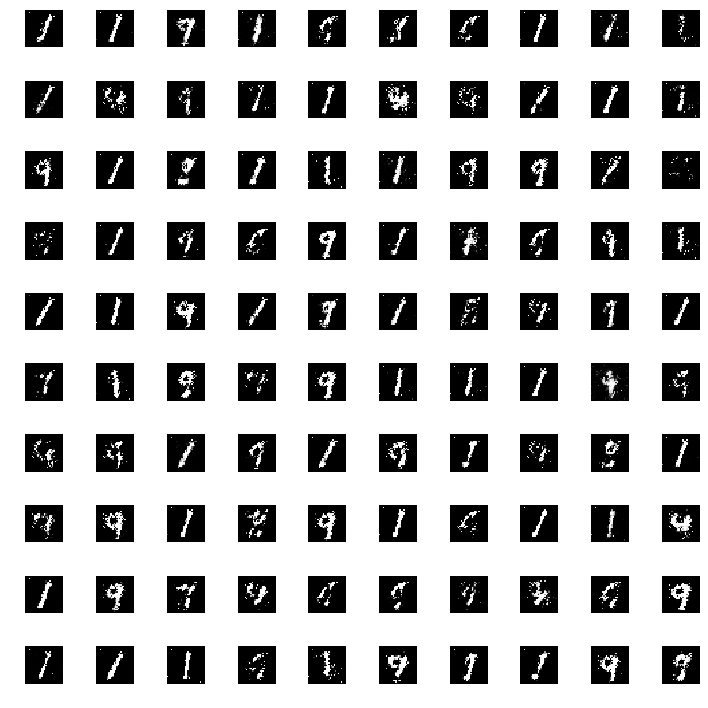

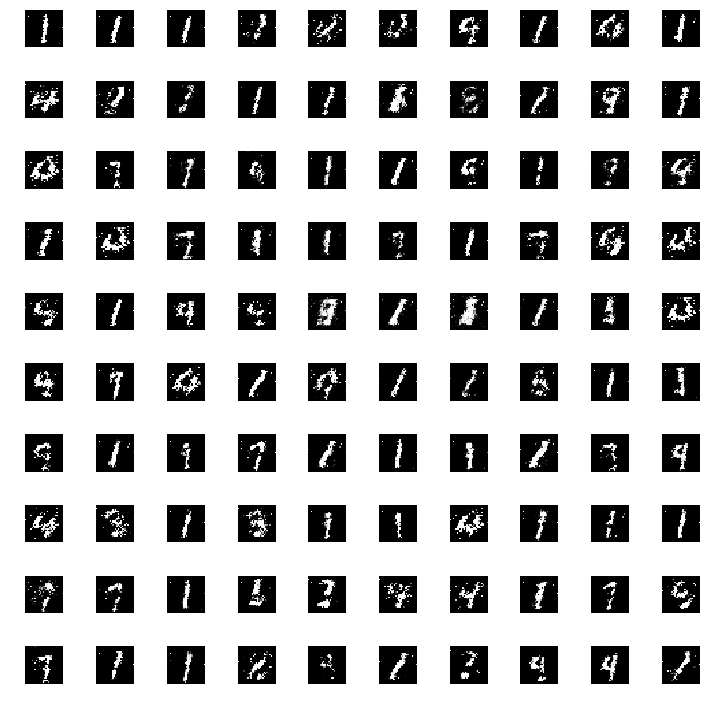

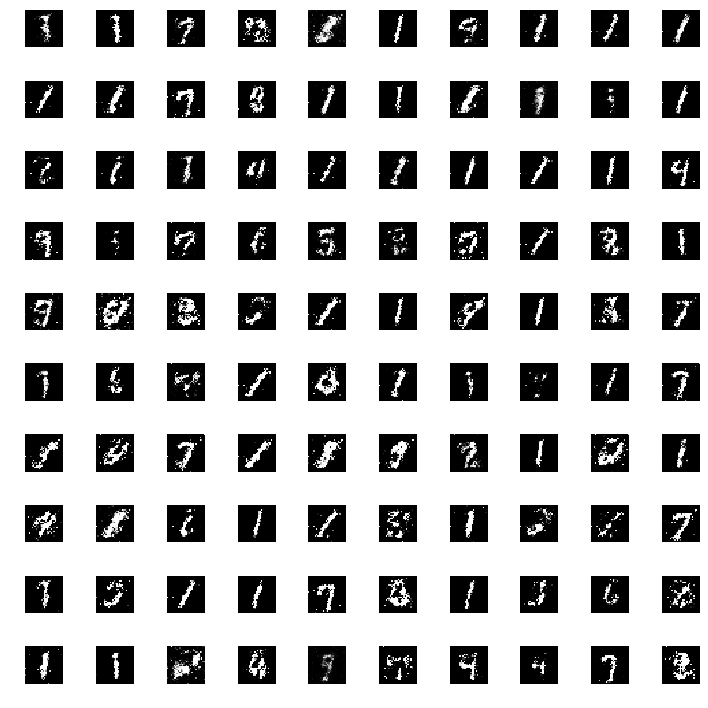

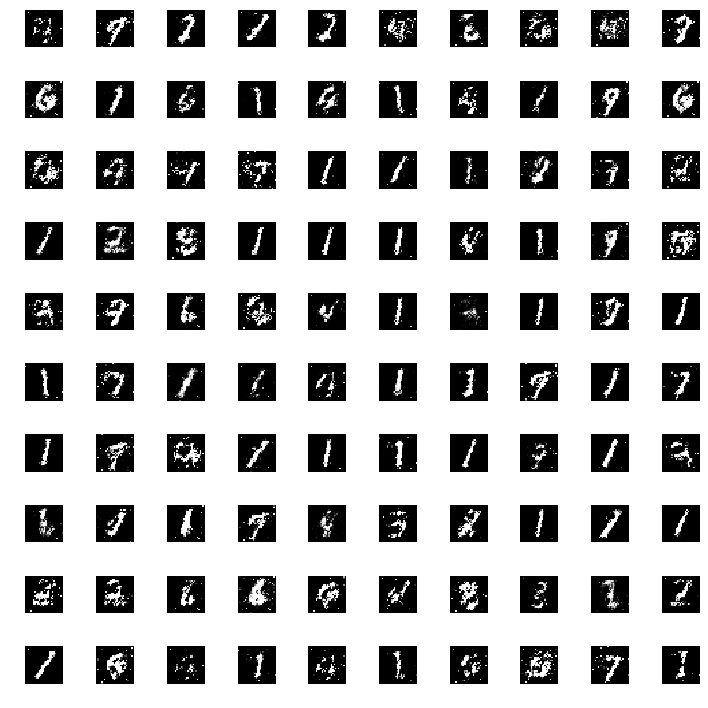

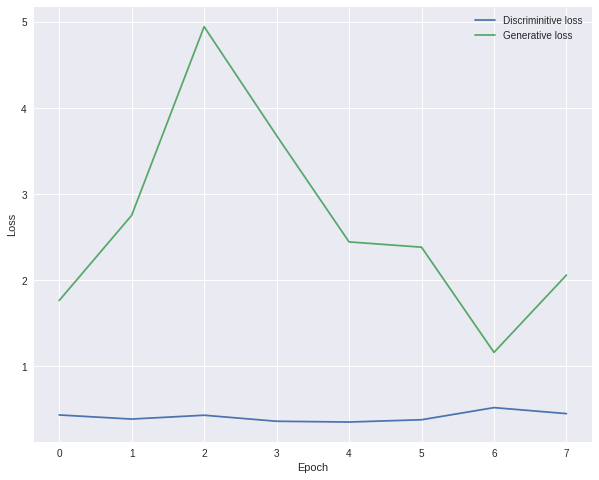

In [15]:

if __name__ == '__main__':
    train(8, 128)

In [33]:
from keras.datasets import mnist
from keras.layers.core import Reshape, Dense, Dropout, Flatten
(X1_train, y1_train), (X1_test, y1_test) = mnist.load_data()

X1_train = X1_train.reshape(60000, 784)
x2=X1_train[1]
x2=x2.reshape(784,1)
print (X1_train.shape)
print x2.shape

(60000, 784)
(784, 1)


In [39]:
from keras.models import load_model
discriminator2=load_model('gan_discriminator_epoch_6.h5')
discriminator2.summary()
generator3=load_model('gan_generator_epoch_6.h5')
generator3.summary()
dim=(100)
x2=x2.reshape(1,784)
print x2.shape
noise = np.random.normal(0, 1, size=[1, 784])
print(noise.shape)
k= discriminator2.predict(noise, batch_size=None, verbose=0, steps=None)
k1= discriminator2.predict(x2, batch_size=None, verbose=0, steps=None)
print k1, k
if k < 0.002:
  print "fake"
else :
  print "real"
if k1 < 0.002:
  print "fake"
else :
  print "real"
#plt.imshow(noise, cmap='gray_r')

#plt.subplot(dim[0], dim[1], i+1)
#print noise
#generatedImages = generator2.predict(noise)
#plt.savefig('gan_generated_image_epoch_12.png')
'''
noise = np.random.normal(0, 1, size=[128, 100])
generatedImages = generator2.predict(noise)
generatedImages = generatedImages.reshape(100, 28, 28)
figsize=(10, 10)
plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
  plt.subplot(dim[0], dim[1], i+1)
  plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
  plt.axis('off')
  plt.tight_layout()
  plt.savefig('gan_generated_image_epoch_12.png')'''
#from google.colab import files


#files.download('gan_generated_image_epoch_12.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               131328    
__________

"\nnoise = np.random.normal(0, 1, size=[128, 100])\ngeneratedImages = generator2.predict(noise)\ngeneratedImages = generatedImages.reshape(100, 28, 28)\nfigsize=(10, 10)\nplt.figure(figsize=figsize)\nfor i in range(generatedImages.shape[0]):\n  plt.subplot(dim[0], dim[1], i+1)\n  plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')\n  plt.axis('off')\n  plt.tight_layout()\n  plt.savefig('gan_generated_image_epoch_12.png')"